In [1]:
"""
An example of how to train an RBM with more control over training parameters

Created by Omid Alemi
"""

%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from IPython import display
import sys
sys.path.append('../')

from xrbm.models.rbm import RBM
from xrbm.utils.vizutils import tile_raster_images
from xrbm.utils import tfutils
import xrbm.train


In [2]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [3]:
data_sets = input_data.read_data_sets('MNIST_data', False)

 # Set up the parameters
training_data = data_sets.train.images
snapshot_dir = './logs/'
snapshot_freq = 100
num_vis = training_data[0].shape[0]
num_hid = 200
learning_rate=0.05
batch_size=100
cd_k=10
wdecay=0.0002
momentum=0.9
training_epochs=30
activation=tf.nn.sigmoid
initializer=tf.contrib.layers.xavier_initializer()
w_regularizer = tf.contrib.layers.l1_regularizer(0.001)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
tf.reset_default_graph()
r1 = RBM(num_vis=num_vis, num_hid=num_hid, vis_type='binary', 
         name='rbm_mnist_custom', activation=activation, initializer=initializer, W_regularizer=w_regularizer)

# Create the tf tensors
r1.create_placeholders_variables()

In [5]:
# Make batches
r1.batch_size = batch_size
batch_idxs = np.random.permutation(range(len(training_data)))
n_batches = len(batch_idxs) // batch_size

In [6]:
# Define train ops            

mom = tf.Variable(initial_value=momentum, dtype=tf.float32)
batch_data_ph = tfutils.data_variable((None,training_data.shape[1]),'batch_data')
# lr = tf.Variable(initial_value=learning_rate, dtype=tf.float32)

# train_op = r1.train_step(batch_data_ph, 
#                             lr, 
#                             mom, 
#                             wdecay, 
#                             cd_k=cd_k)

reccost_op = r1.get_reconstruction_cost(batch_data_ph)

cdlearner = xrbm.train.CDLearner(0.01, momentum=mom, k=10)

train_op = cdlearner.train(r1, vis_data=batch_data_ph)

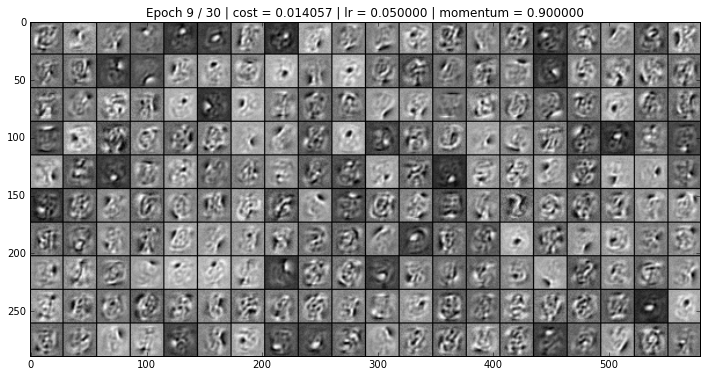

KeyboardInterrupt: 

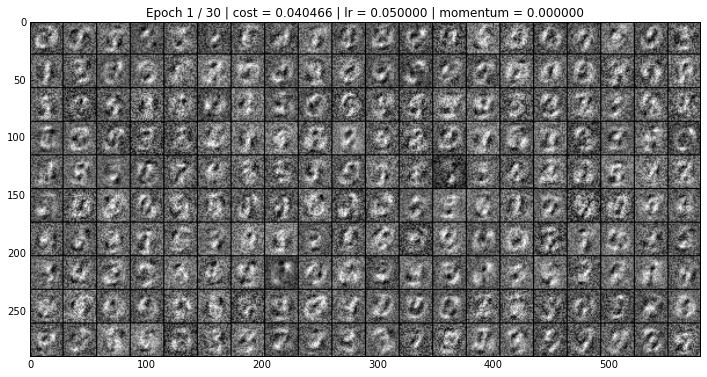

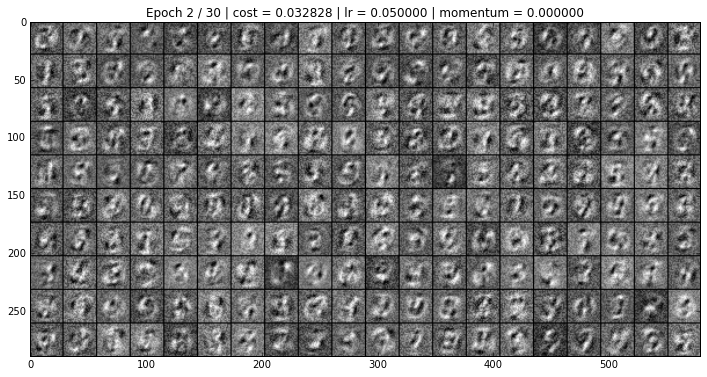

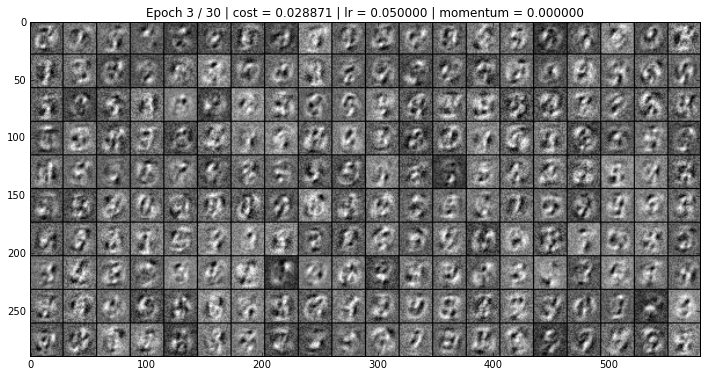

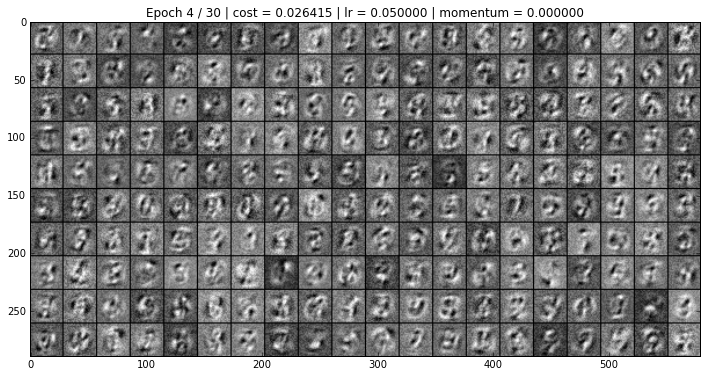

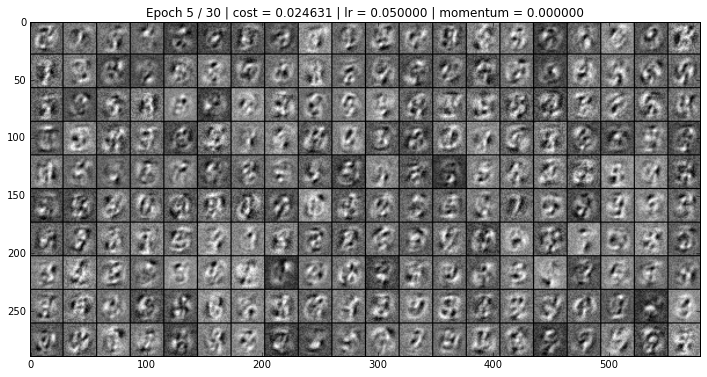

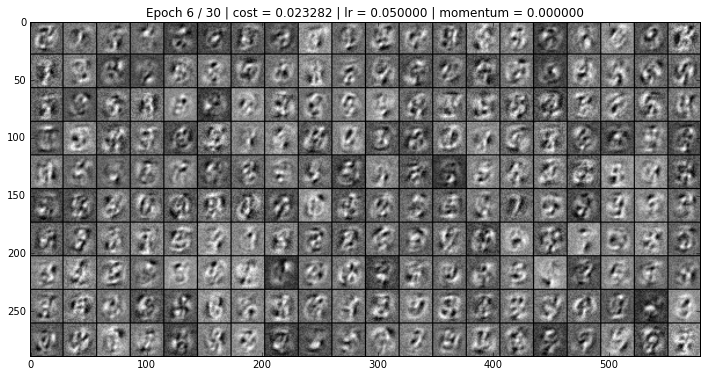

In [ ]:
# Run everything in tf
with tf.Session() as sess:    

    sess.run(tf.global_variables_initializer())

    # Run everything in tf 
    for epoch in range(training_epochs):
        epoch_cost = 0

        m = momentum

        if epoch < 6:
            m = 0
        
        # if epoch > 20:
        #     learning_rate = 0.001

        for batch_i in range(n_batches):
            # Get just minibatch amount of data
            idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

            # Create the feed for the batch data
            feed = feed_dict={batch_data_ph: training_data[idxs_i], mom:m}
            
            # Run the training step
            sess.run(train_op, feed_dict=feed)
            
#             rec_cost = sess.run(reccost_op, feed_dict={batch_data_ph: training_data[idxs_i]})

            # Add up the cost
#             epoch_cost += rec_cost
    
#         epoch_cost = epoch_cost/n_batches
    
        rec_cost = sess.run(reccost_op, feed_dict={batch_data_ph: training_data})
        epoch_cost = rec_cost
        

        _W = r1.W.eval().transpose()

        image = Image.fromarray(
            tile_raster_images(
                X=_W,
                img_shape=(28,28),
                tile_shape=(10, 20),
                tile_spacing=(1, 1)
            )
        )
        
        title = ('Epoch %i / %i | cost = %f | lr = %f | momentum = %f'%
                (epoch+1, training_epochs, epoch_cost, learning_rate, m))
        
        ax = plt.figure(figsize=(12,8))
        plt.title(title)
        plt.imshow(image, cmap='gray')
        display.clear_output(wait=True)
        display.display(ax)
        